In [1]:
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

# PyTorch
import torch
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool, global_max_pool, global_add_pool
import torch.nn.functional as F

# sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

# cust_functions folder
from cust_functions.training import *
from cust_functions.graph_networks import *
from cust_functions.graph_creation import *

In [2]:
SEED = 42
set_seed(SEED)

In [3]:
# Load data
input_data = pd.read_csv("aki_data/test_data.tsv", sep="\t", )
input_data_qm = pd.read_csv("aki_data/test_qm.csv")
translation = pd.read_csv("aki_data/translation.tsv", sep="\t", index_col=0)
pathways = pd.read_csv("aki_data/pathways.tsv", sep="\t")
design_matrix = pd.read_csv("aki_data/design_matrix.tsv", sep="\t")

# Preprocess input data
input_data_preprocessed = input_data_qm.fillna(0)
design_matrix = design_matrix.replace(1, 0)
design_matrix = design_matrix.replace(2, 1)

In [7]:
translation

,input,translation
1323,A0A075B6P5,R-HSA-166663
1324,A0A075B6P5,R-HSA-173623
1325,A0A075B6P5,R-HSA-198933
1326,A0A075B6P5,R-HSA-202733
1327,A0A075B6P5,R-HSA-2029481
...,...,...
311659,Q9Y6Y9,R-HSA-937072
311660,Q9Y6Y9,R-HSA-9707616
311661,Q9Y6Y9,R-HSA-975163
311662,Q9Y6Z7,R-HSA-166662


Number of nodes:  2585
Number of edges:  2603
Number of nodes with no edges:  0
Mean number of edges per node:  2.0
Max number of edges per node:  72
Min number of edges per node:  1
Median number of edges per node:  1.0
Number of nodes without proteins:  424


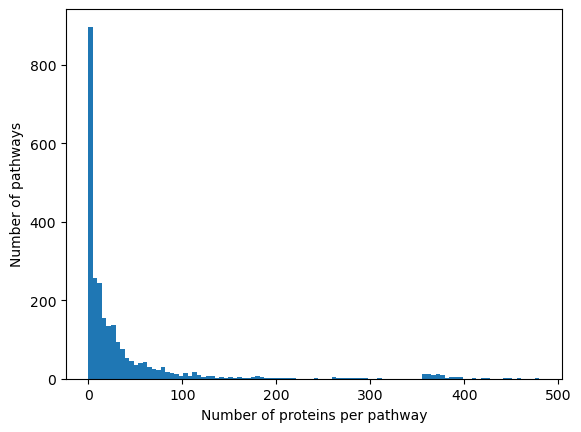

In [4]:
# Initialize graph
G = create_pathway_graph(pathways, translation, descendants=True)

print("Number of nodes: ", len(G.nodes))
print("Number of edges: ", len(G.edges))
print("Number of nodes with no edges: ", len([n for n in G.nodes if G.degree(n)==0]))
print("Mean number of edges per node: ", np.round(np.mean([G.degree(n) for n in G.nodes]),1))
print("Max number of edges per node: ", np.max([G.degree(n) for n in G.nodes]))
print("Min number of edges per node: ", np.min([G.degree(n) for n in G.nodes]))
print("Median number of edges per node: ", np.median([G.degree(n) for n in G.nodes]))
print("Number of nodes without proteins: ", len([n for n in G.nodes if len(G.nodes[n].get('proteins', '') )==0]))

# collect number of proteins per pathway
num_proteins_per_pathway = [len(G.nodes[node].get('proteins', '')) for node in G.nodes()]
plt.hist(num_proteins_per_pathway, bins=100)
plt.xlabel("Number of proteins per pathway")
plt.ylabel("Number of pathways")
plt.show()


## 2.0 Model pipelines

### 2.3 All proteins as features

In [5]:
patient_ids = design_matrix['sample'].values
protein_names = input_data_preprocessed['Protein'].tolist()

# Dictionary to store feature vectors for each patient
patient_features = {patient_id: [] for patient_id in patient_ids}

# Initialize a feature matrix for each pathway per patient
for patient_id in patient_ids:
    pathway_features = np.zeros((len(G.nodes()), len(protein_names)))
    for i, pathway in enumerate(G.nodes()):
        proteins_in_pathway = G.nodes[pathway].get('proteins', [])
        for j, protein in enumerate(protein_names):
            if protein in proteins_in_pathway:
                pathway_features[i, j] = input_data_preprocessed.loc[input_data_preprocessed['Protein'] == protein, patient_id].values[0]

    patient_features[patient_id] = pathway_features  



In [6]:
train_graph_data, test_graph_data = [], []

for patient_id in patient_ids:
    graph = G.copy()

    # Get the PCA-reduced features for this patient
    features = patient_features[patient_id]

    # Convert NetworkX graph to PyTorch Geometric Data
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)


print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])

Number of training graphs: 141
Number of test graphs: 56
Number of features: 554
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 554], edge_index=[2, 2603], y=[1])


In [7]:
# save the graph data
with open("aki_data/train_graph_data.pkl", "wb") as f:
    pickle.dump(train_graph_data, f)

with open("aki_data/test_graph_data.pkl", "wb") as f:
    pickle.dump(test_graph_data, f)

In [8]:
# Load the graph data
with open("aki_data/train_graph_data.pkl", "rb") as f:
    train_graph_data = pickle.load(f)

#### 2.3.1 GCN

Cross validaton

In [42]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0001
weight_decay = 0.05
batch_size = 32
layer_configs = [{"in_channels": 32, "out_channels": 32, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.3}]

# Initialize model
num_features = train_graph_data[0].num_features
num_classes = 2
create_model_fn = lambda: ResGCN(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5
use_scheduler = False

# Saving configurations
save_models = False

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path,
                   save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 1.8356, Val Loss: 0.7790, Val Acc: 0.5862, Val F1 Macro: 0.3696
Epoch: 6, Train Loss: 1.1960, Val Loss: 0.6920, Val Acc: 0.5517, Val F1 Macro: 0.4155
Epoch: 11, Train Loss: 1.2434, Val Loss: 0.6781, Val Acc: 0.4828, Val F1 Macro: 0.3759
Epoch: 16, Train Loss: 1.0150, Val Loss: 0.6681, Val Acc: 0.4828, Val F1 Macro: 0.3759
Epoch: 21, Train Loss: 0.8920, Val Loss: 0.6538, Val Acc: 0.5517, Val F1 Macro: 0.4155
Epoch: 26, Train Loss: 0.8762, Val Loss: 0.6467, Val Acc: 0.5862, Val F1 Macro: 0.5421
Epoch: 31, Train Loss: 0.8299, Val Loss: 0.6384, Val Acc: 0.5862, Val F1 Macro: 0.5421
Epoch: 36, Train Loss: 0.6142, Val Loss: 0.6358, Val Acc: 0.6552, Val F1 Macro: 0.6338
Epoch: 41, Train Loss: 0.7280, Val Loss: 0.6201, Val Acc: 0.6552, Val F1 Macro: 0.6338
Epoch: 46, Train Loss: 0.7224, Val Loss: 0.6040, Val Acc: 0.7586, Val F1 Macro: 0.7539
Epoch: 51, Train Loss: 0.6722, Val Loss: 0.5971, Val Acc: 0.8276, Val F1 Macro: 0.8268
Epoch: 56, Train L

Average validation accuracy: 0.965 +/- 0.02
Average validation roc_auc: 0.981 +/- 0.01
Average validation f1_macro: 0.964 +/- 0.02
Average validation f1_phen1: 0.968 +/- 0.02
Average validation f1_phen2: 0.96 +/- 0.02
Average validation recall_phen1: 0.951 +/- 0.05
Average validation recall_phen2: 0.983 +/- 0.03
Average validation precision_phen1: 0.988 +/- 0.02
Average validation precision_phen2: 0.941 +/- 0.05


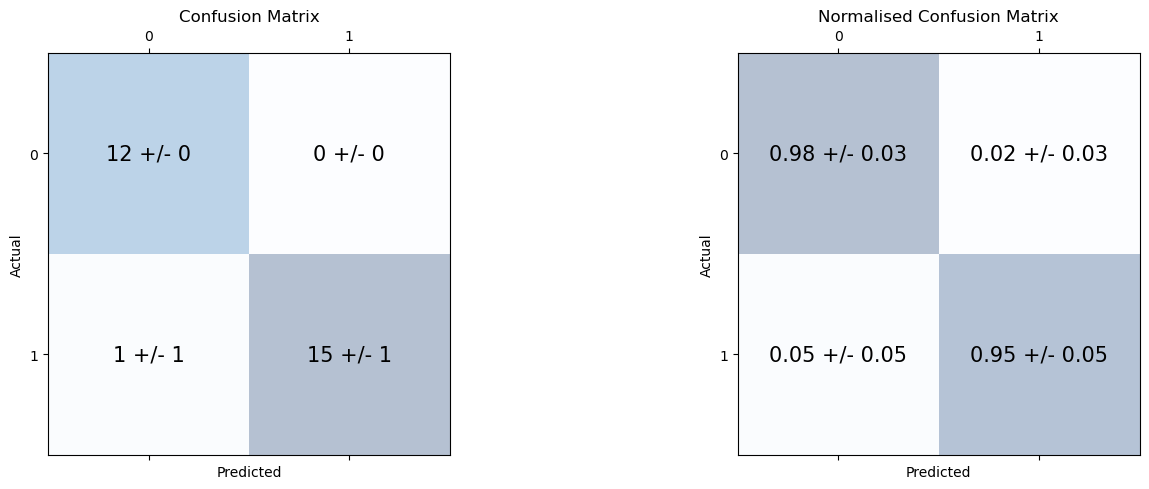

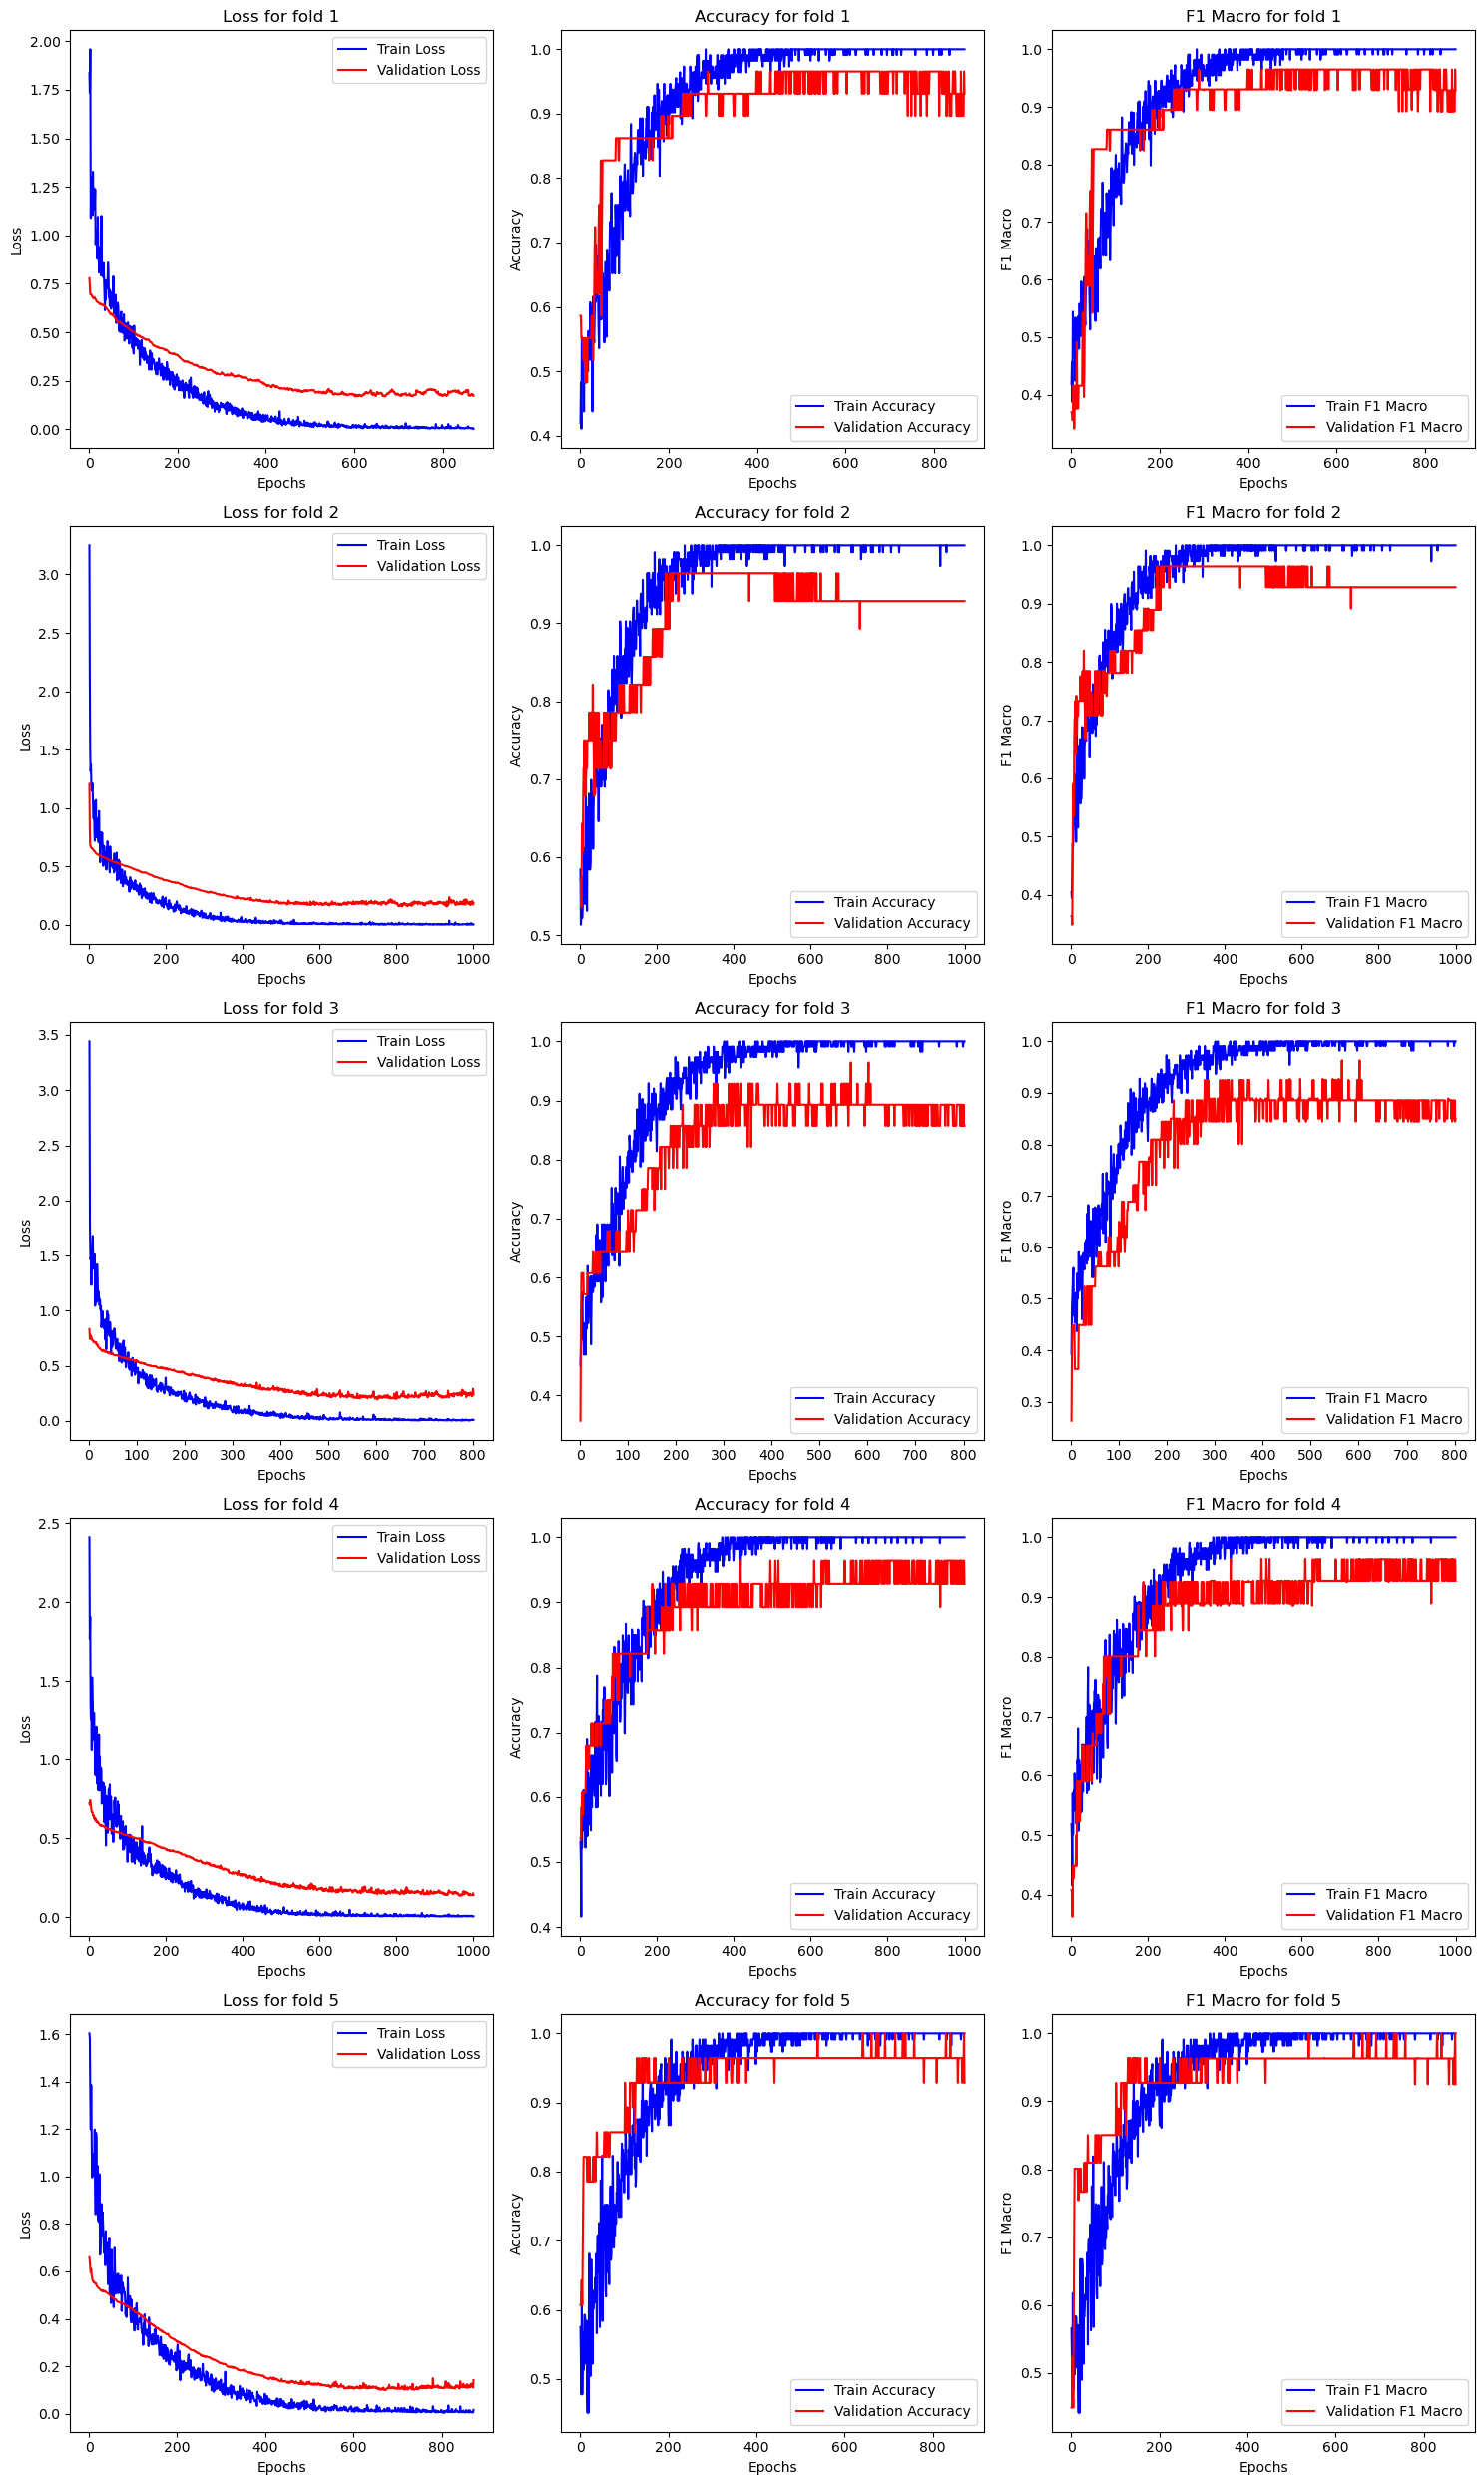

In [43]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

Testing

In [46]:
# run full training on best model
num_epochs = 800
save_path = "trained_models/ResGCN"
run_training(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, batch_size, num_epochs, device, save_path, use_scheduler = True)

# test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# load model on test data
model = ResGCN(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device)
model.load_state_dict(torch.load(f"{save_path}.pt"))
model.eval()

# test
_, test_confusion_matrix, test_roc_auc = validate(test_loader, model, loss_fn, device)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro= calculate_metrics(test_confusion_matrix)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")


Test Accuracy: 0.8929
Test ROC_AUC: 0.9541
Test F1 Macro: 0.8687
Test F1 Phen1: 0.9250
Test F1 Phen2: 0.8125
Test Recall Phen1: 0.8810
Test Recall Phen2: 0.9286


#### 2.3.2 GAT

In [50]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0001
weight_decay = 0.1
batch_size = 32
layer_configs = [{"in_channels": 64, "out_channels": 64, "heads": 2, "dropout_rate": 0.5, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1}]

# Initialize model
num_features = train_graph_data[0].num_features
num_classes = 2
create_model_fn = lambda: ResGAT(num_features, layer_configs, mlp_config, num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.25)
use_scheduler = False

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5

# Saving configurations
save_models = False
save_path = "trained_models/ResGAT"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path,
                  save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS)

Using device: cuda
Fold: 1
Epoch: 1, Train Loss: 2.6033, Val Loss: 0.6143, Val Acc: 0.6552, Val F1 Macro: 0.6548
Epoch: 6, Train Loss: 0.7903, Val Loss: 0.5356, Val Acc: 0.7586, Val F1 Macro: 0.7387
Epoch: 11, Train Loss: 0.7577, Val Loss: 0.5297, Val Acc: 0.7241, Val F1 Macro: 0.7071
Epoch: 16, Train Loss: 0.5827, Val Loss: 0.5155, Val Acc: 0.7586, Val F1 Macro: 0.7387
Epoch: 21, Train Loss: 0.4975, Val Loss: 0.5153, Val Acc: 0.7931, Val F1 Macro: 0.7803
Epoch: 26, Train Loss: 0.4356, Val Loss: 0.5099, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 31, Train Loss: 0.4495, Val Loss: 0.5024, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 36, Train Loss: 0.4374, Val Loss: 0.4888, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 41, Train Loss: 0.4086, Val Loss: 0.4808, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 46, Train Loss: 0.3707, Val Loss: 0.4764, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 51, Train Loss: 0.2678, Val Loss: 0.4763, Val Acc: 0.7586, Val F1 Macro: 0.7478
Epoch: 56, Train L

KeyboardInterrupt: 

Average validation accuracy: 0.922 +/- 0.03
Average validation roc_auc: 0.979 +/- 0.01
Average validation f1_macro: 0.919 +/- 0.03
Average validation f1_phen1: 0.934 +/- 0.02
Average validation f1_phen2: 0.903 +/- 0.03
Average validation recall_phen1: 0.963 +/- 0.03
Average validation recall_phen2: 0.867 +/- 0.07
Average validation precision_phen1: 0.908 +/- 0.05
Average validation precision_phen2: 0.948 +/- 0.04


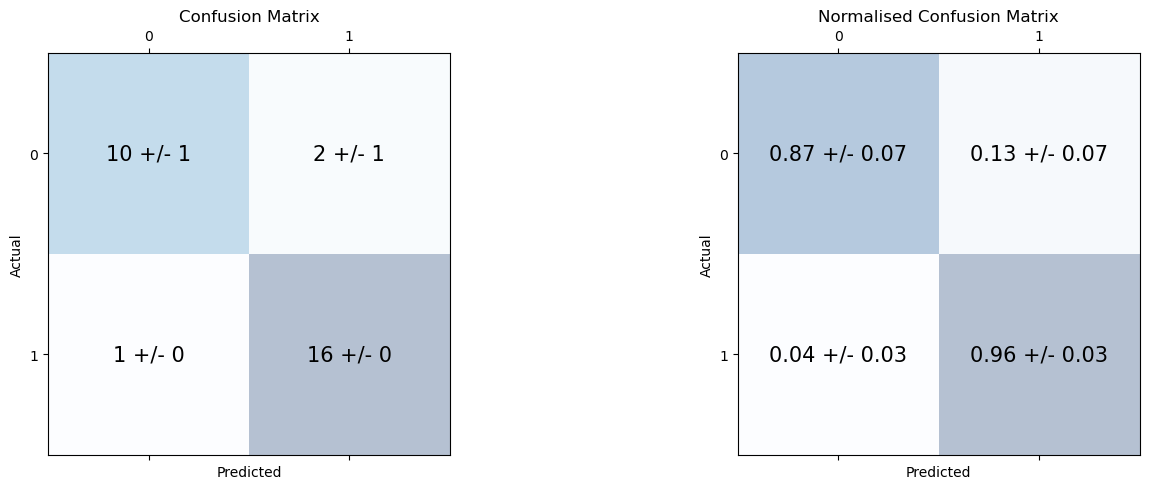

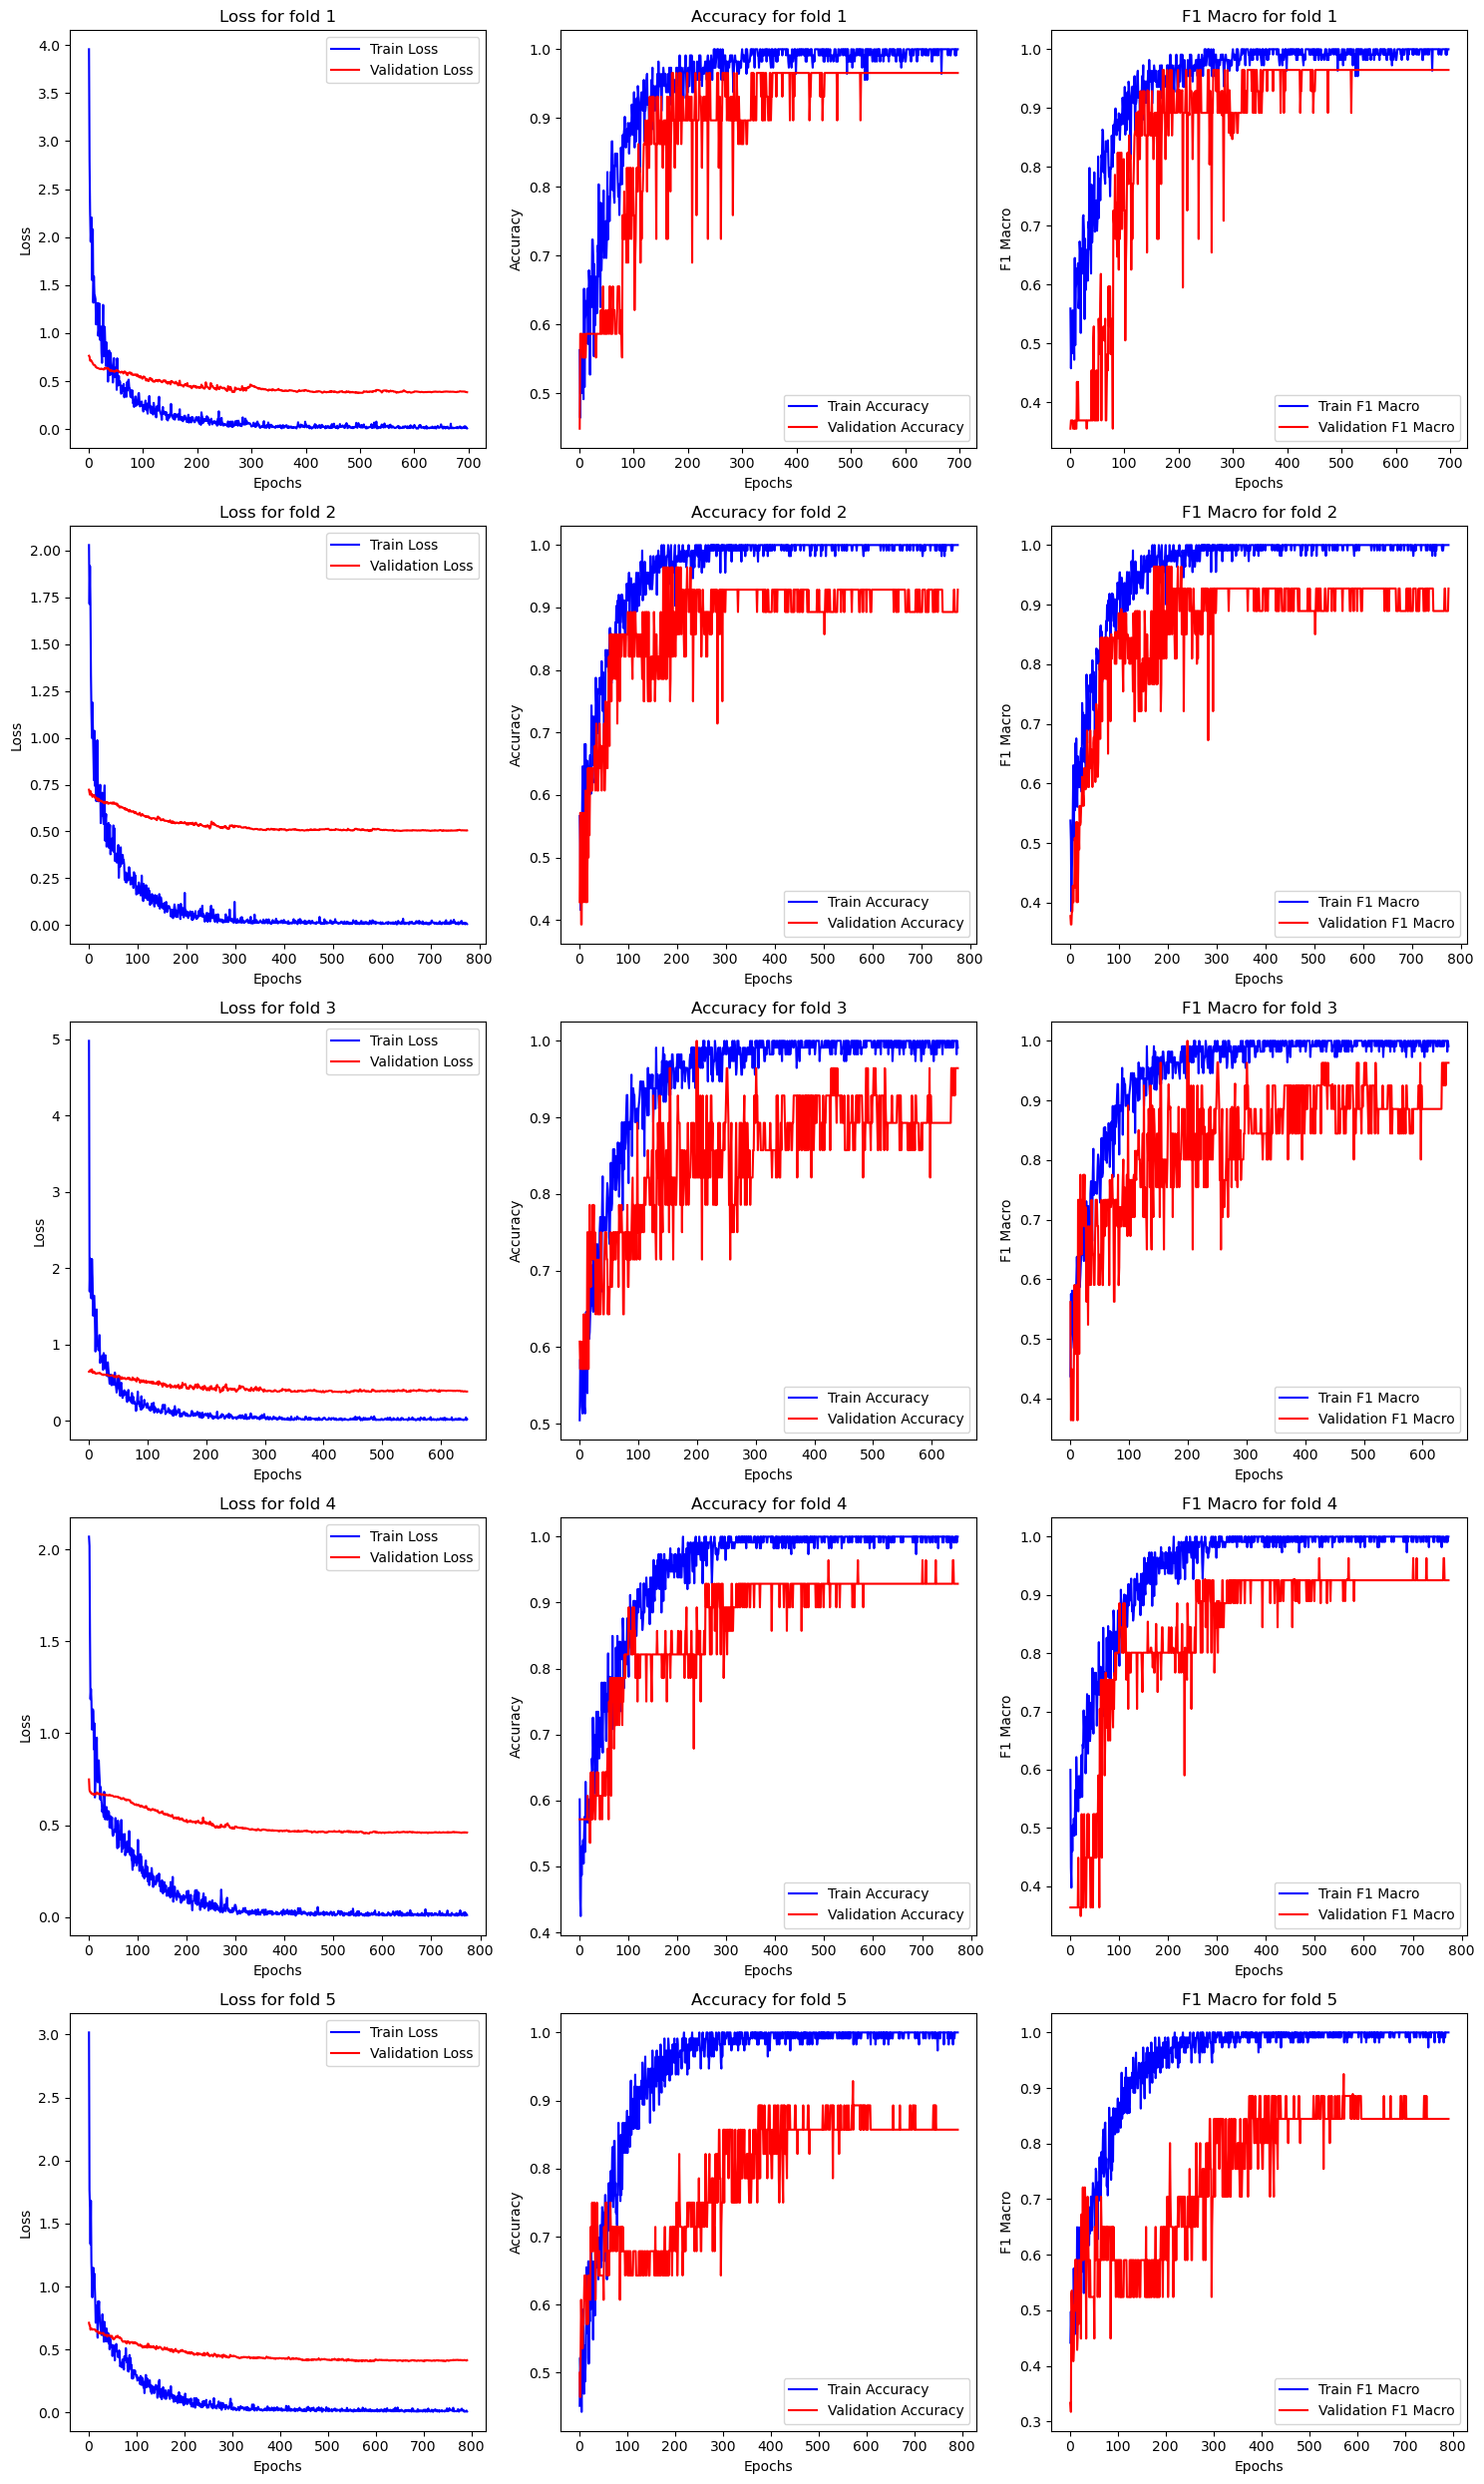

In [27]:
print_val_results(results)
plot_confusion_matrix(results)
plot_results(results, FOLDS)

In [16]:
# run full training on best model
num_epochs = 400
save_path = "trained_models/ResGAT"
run_training(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, batch_size, num_epochs, device, save_path, use_scheduler = True)

# test data
test_loader = DataLoader(test_graph_data, batch_size=1)

# load model on test data
model = ResGAT(train_graph_data[0].num_features, layer_configs, mlp_config, 2).to(device)
model.load_state_dict(torch.load(f"{save_path}.pt"))
model.eval()

# test
_, test_confusion_matrix, test_roc_auc = validate(test_loader, model, loss_fn, device)
recall_phen1, recall_phen2, precision_phen1, precision_phen2, accuracy, f1_phen1, f1_phen2, f1_macro= calculate_metrics(test_confusion_matrix)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC_AUC: {test_roc_auc:.4f}")
print(f"Test F1 Macro: {f1_macro:.4f}")
print(f"Test F1 Phen1: {f1_phen1:.4f}")
print(f"Test F1 Phen2: {f1_phen2:.4f}")
print(f"Test Recall Phen1: {recall_phen1:.4f}")
print(f"Test Recall Phen2: {recall_phen2:.4f}")


Test Accuracy: 0.9464
Test ROC_AUC: 0.9966
Test F1 Macro: 0.9268
Test F1 Phen1: 0.9647
Test F1 Phen2: 0.8889
Test Recall Phen1: 0.9762
Test Recall Phen2: 0.8571


In [6]:
def run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path = None, 
                 save = True, use_scheduler = True, early_stopping_patience = 30, SEED = 42, FOLDS = 3, hierarchical = False):
    results = {}
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)


    for fold, (train_idx, test_idx) in enumerate(skf.split(train_graph_data, train_labels)):
        print(f"Fold: {fold + 1}")
        train_loader = DataLoader([train_graph_data[i] for i in train_idx], batch_size=batch_size)
        val_loader = DataLoader([train_graph_data[i] for i in test_idx], batch_size=batch_size)

        model = create_model_fn().to(device)
        optimizer = optimizer_fn(model.parameters())
        if use_scheduler:
            scheduler = scheduler_fn(optimizer)

        best_val_loss = np.inf
        best_model = None
        patience = early_stopping_patience
        best_epoch = 0

        for epoch in range(num_epochs):
            if hierarchical:
                train_loss, train_cm, train_roc_auc = train(train_loader, model, optimizer, loss_fn, device, hierarchical = True)
            else:
                train_loss, train_cm, train_roc_auc = train(train_loader, model, optimizer, loss_fn, device)
            if hierarchical:
                val_loss, val_cm, val_roc_auc = validate(val_loader, model, loss_fn, device, hierarchical = True)
            else:
                val_loss, val_cm, val_roc_auc = validate(val_loader, model, loss_fn, device)
            results = update_results(results, fold, epoch, train_loss, train_cm, train_roc_auc, val_loss, val_cm, val_roc_auc)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = model.state_dict().copy()
                patience = early_stopping_patience
                best_epoch = epoch + 1
                results[fold + 1]['best_val_epoch'] = best_epoch
            else:
                patience -= 1
                if patience == 0:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break

            if use_scheduler:
                scheduler.step()

            
            if epoch % 5 == 0:
                print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {results[fold + 1]['val_accuracy'][-1]:.4f}, Val F1 Macro: {results[fold + 1]['val_f1_macro'][-1]:.4f}")

        if save:
            model.load_state_dict(best_model)
            best_acc = np.round(results[fold + 1]['val_accuracy'][best_epoch - 1],2)
            best_f1_macro = np.round(results[fold + 1]['val_f1_macro'][best_epoch - 1],2)
            best_roc_auc = np.round(results[fold + 1]['val_roc_auc'][best_epoch - 1],2)
            save_fold_path = f"{save_path}_fold_{fold + 1}_Acc_{best_acc}_F1_{best_f1_macro}_AUC_{best_roc_auc}.pt"
            torch.save(model.state_dict(), save_fold_path)

    return results

def run_training(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, batch_size, num_epochs, device, save_path, use_scheduler = True):

    train_loader = DataLoader(train_graph_data, batch_size=batch_size)
    model = create_model_fn().to(device)
    optimizer = optimizer_fn(model.parameters())
    if use_scheduler:
        scheduler = scheduler_fn(optimizer)

    for epoch in range(num_epochs):
        train_loss, _, _ = train(train_loader, model, optimizer, loss_fn, device)

        if use_scheduler:
            scheduler.step()

    save_fold_path = f"{save_path}.pt"
    torch.save(model.state_dict(), save_fold_path)



def train(train_data, model, optimizer, loss_fn, device, hierarchical = False):
    model.train()
    running_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_data:
        batch = batch.to(device, non_blocking=True)

        optimizer.zero_grad()
        if hierarchical:
            out = model(batch.x, batch.edge_index, batch.batch, batch.node_hierarchy)
            print(out)
        else:
            out = model(batch.x, batch.edge_index, batch.batch)
        train_loss = loss_fn(out, batch.y)
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()

        preds = torch.softmax(out, dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(batch.detach().y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    roc_auc = roc_auc_score(all_labels, all_preds[:, 1])

    pred_labels = np.argmax(all_preds, axis=1)
    cm = confusion_matrix(all_labels, pred_labels, labels=[0, 1])

    return running_loss / len(train_data), cm, roc_auc

def validate(test_data, model, loss_fn, device, hierarchical = False):
    model.eval()
    running_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_data:
            batch = batch.to(device)
            if hierarchical:
                out = model(batch.x, batch.edge_index, batch.batch, batch.node_hierarchy)
            else:
                out = model(batch.x, batch.edge_index, batch.batch)
            loss = loss_fn(out, batch.y)
            running_loss += loss.item()

            preds = torch.softmax(out, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch.y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    roc_auc = roc_auc_score(all_labels, all_preds[:, 1])

    pred_labels = np.argmax(all_preds, axis=1)
    cm = confusion_matrix(all_labels, pred_labels, labels=[0, 1])

    return running_loss / len(test_data), cm, roc_auc




#### 2.3.3 Hierarchical GCN

In [65]:
class HierarchicalGraphConvolution(torch.nn.Module):
    def __init__(self, in_channels, out_channels, attention_size):
        super(HierarchicalGraphConvolution, self).__init__()
        self.conv = GCNConv(in_channels, out_channels)
        self.attention_weights = torch.nn.Parameter(torch.Tensor(out_channels, attention_size))
        self.self_influence = torch.nn.Parameter(torch.Tensor(out_channels, attention_size))
        self.self_loop_filter = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        # Graph convolution
        x_conv = self.conv(x, edge_index, edge_weight)
        #print('x_conv: ', x_conv.shape)

        # Attention mechanism
        attention_scores = torch.tanh(torch.matmul(x_conv, self.attention_weights))
        #print('attention_scores: ', attention_scores.shape)
        attention_scores = F.softmax(attention_scores, dim=1)
        #print('attention_scores: ', attention_scores.shape)

        # Self-influence
        self_influence_scores = torch.sigmoid(torch.matmul(x_conv, self.self_influence))
        #print('self_influence_scores: ', self_influence_scores.shape)
        self_loop = self.self_loop_filter(x) * self_influence_scores
        #print('self_loop: ', self_loop.shape)

        return x_conv + self_loop
    
def update_edge_index(edge_index, nodes_to_keep):
    # Create a mapping from old indices to new indices
    new_indices = torch.arange(nodes_to_keep.size(0), device=edge_index.device)
    old_to_new = dict(zip(nodes_to_keep.cpu().numpy(), new_indices.cpu().numpy()))

    # Apply the mapping to the edge_index tensor
    for i in range(edge_index.size(1)):
        edge_index[0, i] = old_to_new.get(edge_index[0, i].item(), -1)
        edge_index[1, i] = old_to_new.get(edge_index[1, i].item(), -1)

    # Remove edges that have -1 (invalid node reference)
    mask = (edge_index[0] != -1) & (edge_index[1] != -1)
    return edge_index[:, mask]


def update_batch(batch, nodes_to_keep):
    """ Update the batch tensor to match the pooled nodes. """
    # Create a mask for nodes to keep
    mask = torch.zeros_like(batch, dtype=torch.bool)
    mask[nodes_to_keep] = True

    # Apply the mask to the batch tensor
    updated_batch = batch[mask]

    # Re-index batch tensor
    unique_batches = torch.unique(batch)
    for i, unique_batch in enumerate(unique_batches):
        updated_batch[updated_batch == unique_batch] = i

    return updated_batch

def hierarchical_pooling(x, node_hierarchy, current_level, batch):
    """ Hierarchical pooling based on the current level. """
    nodes_to_keep = torch.nonzero(node_hierarchy != current_level).squeeze()
    #print('nodes_to_keep: ', nodes_to_keep.shape)
    x_pooled = x[nodes_to_keep]
    updated_node_hierarchy = node_hierarchy[nodes_to_keep]
    updated_batch = update_batch(batch, nodes_to_keep)
    return x_pooled, updated_node_hierarchy, nodes_to_keep, updated_batch


class GUIDEModel(torch.nn.Module):
    def __init__(self, num_layers, in_channels, hidden_channels, out_channels, attention_size, mlp_config, num_classes):
        super(GUIDEModel, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(HierarchicalGraphConvolution(in_channels, hidden_channels, attention_size))

        for _ in range(num_layers - 2):
            self.layers.append(HierarchicalGraphConvolution(hidden_channels, hidden_channels, attention_size))

        self.layers.append(HierarchicalGraphConvolution(hidden_channels, out_channels, attention_size))

        # Configurable MLP
        mlp_layers = []
        prev_channels = out_channels
        for layer in mlp_config:
            mlp_layers.append(torch.nn.Linear(prev_channels, layer['out_channels']))
            if layer.get('batch_norm', False):
                mlp_layers.append(torch.nn.BatchNorm1d(layer['out_channels']))
            if layer.get('relu', True):
                mlp_layers.append(torch.nn.ReLU())
            if 'dropout_rate' in layer:
                mlp_layers.append(torch.nn.Dropout(layer['dropout_rate']))
            prev_channels = layer['out_channels']

        mlp_layers.append(torch.nn.Linear(prev_channels, num_classes))
        self.mlp = torch.nn.Sequential(*mlp_layers)

    def forward(self, x, edge_index, batch, node_hierarchy):

        #print('batch shape: ', batch.shape)
        for current_level, conv in enumerate(self.layers):
            #print('current level: ', current_level)
            #print('x shape: ', x.shape)
            x = conv(x, edge_index)
            print('x shape after conv: ', x.shape)
            x, node_hierarchy, nodes_to_keep, batch = hierarchical_pooling(x, node_hierarchy, current_level, batch)
            #print('x shape after pooling: ', x.shape)
            edge_index = update_edge_index(edge_index, nodes_to_keep)
            #print('edge_index shape: ', edge_index.shape)
            #print('batch shape: ', batch.shape)

        #print('x shape before global pooling: ', x.shape)
        # Global pooling
        x = global_max_pool(x, batch)

        # MLP for classification
        x = self.mlp(x)

        return x




In [50]:
def determine_hierarchy_levels(graph):
    hierarchy_levels = {}
    # Identify root nodes (no incoming edges)
    root_nodes = [node for node in graph.nodes() if graph.in_degree(node) == 0]

    # Initialize root nodes with level 0
    for root in root_nodes:
        hierarchy_levels[root] = 0
        for child in nx.descendants(graph, root):
            # Level is the shortest path from any root to the node
            hierarchy_levels[child] = nx.shortest_path_length(graph, source=root, target=child)

    return hierarchy_levels

node_hierarchy = determine_hierarchy_levels(G)

In [46]:
train_graph_data, test_graph_data = [], []

for patient_id in patient_ids:
    graph = G.copy()
    features = patient_features[patient_id]
    edge_index = map_edges_to_indices(graph.edges)
    x = torch.tensor(features, dtype=torch.float)

    # Add hierarchy levels as a node feature or separate tensor
    hierarchy_levels = torch.tensor([node_hierarchy[node] for node in graph.nodes()], dtype=torch.long)
    y = torch.tensor([design_matrix[design_matrix['sample'] == patient_id]['group'].iloc[0]], dtype=torch.long)
    graph_data = Data(x=x, edge_index=edge_index, y=y, node_hierarchy=hierarchy_levels)

    if 'M2012' in patient_id:
        train_graph_data.append(graph_data)
    else:
        test_graph_data.append(graph_data)



print(f"Number of training graphs: {len(train_graph_data)}")
print(f"Number of test graphs: {len(test_graph_data)}")
print(f"Number of features: {train_graph_data[0].num_features}")
print(f"Number of classes: {np.unique([graph.y.detach().numpy()[0] for graph in train_graph_data])}")
print(f"Is directed: {train_graph_data[0].is_directed()}")
print(train_graph_data[0])


Number of training graphs: 141
Number of test graphs: 56
Number of features: 554
Number of classes: [0 1]
Is directed: True
Data(x=[2585, 554], edge_index=[2, 2603], y=[1], node_hierarchy=[2585])


In [20]:
torch.max(train_graph_data[0].node_hierarchy)

tensor(8)

In [25]:
# print nodes at levl 2
counter = 3
for node in G.nodes():
    if node_hierarchy[node] == 1:
        counter += 1
print(counter)

167


In [70]:
# Set device
device = torch.device('cpu')
print(f"Using device: {device}")

# Hyperparameters
lr = 0.0001
weight_decay = 0.7
batch_size = 16
layer_configs = [{"in_channels": 32, "out_channels": 32, "dropout_rate": 0.6, "batch_norm": True, "residual": True}]
mlp_config = [{"out_channels": 64, "relu": True, "batch_norm": False, "dropout_rate": 0.1}]

# Initialize model
num_features = train_graph_data[0].num_features
print('num_features: ', num_features)
num_classes = 2
create_model_fn = lambda: GUIDEModel(num_layers = 4, in_channels = num_features, hidden_channels = 32, out_channels = 32, attention_size = 32, mlp_config = mlp_config, num_classes = num_classes)

# Initialize loss function, optimizer and scheduler
loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
scheduler_fn = lambda optimizer: torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

# Training configurations
train_labels = design_matrix['group'][design_matrix['sample'].str.contains('M2012')]
num_epochs = 1000
early_stopping_patience = 200
FOLDS = 5
use_scheduler = True

# Saving configurations
save_models = False
save_path = "trained_models/GUIDE"

# Run cross-validation
results = run_cv(create_model_fn, loss_fn, optimizer_fn, scheduler_fn, train_graph_data, train_labels, batch_size, num_epochs, device, save_path,
                    save = save_models, use_scheduler = use_scheduler, early_stopping_patience = early_stopping_patience, SEED = SEED, FOLDS = FOLDS, hierarchical = True)

Using device: cpu
num_features:  554
Fold: 1
x shape after conv:  torch.Size([41360, 32])
x shape after conv:  torch.Size([40896, 32])
x shape after conv:  torch.Size([38272, 32])
x shape after conv:  torch.Size([30992, 32])
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<AddmmBackward0>)
x shape after conv:  torch.Size([41360, 32])
x shape after conv:  torch.Size([40896, 32])
x shape after conv:  torch.Size([38272, 32])
x shape after conv:  torch.Size([30992, 32])
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        

KeyboardInterrupt: 